In [2]:
%load_ext autoreload
%autoreload 2

In [56]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.nn import DragonNet
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset.regression import *
from causalml.metrics import *

import os, sys

%matplotlib inline

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12,8)

# IHDP semi-synthetic dataset

Hill introduced a semi-synthetic dataset constructed from the Infant Health
and Development Program (IHDP). This dataset is based on a randomized experiment
investigating the effect of home visits by specialists on future cognitive scores. The data has 747 observations (rows). The IHDP simulation is considered the de-facto standard benchmark for neural network treatment effect
estimation methods.

The original [paper](https://arxiv.org/pdf/1906.02120.pdf) uses 1000 realizations from the NCPI package, but for illustration purposes, we use 1 dataset (realization) as an example below. 

In [73]:
df = pd.read_csv(f'data/ihdp_npci_3.csv', header=None)
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [f'x{i}' for i in range(1,26)]
df.columns = cols

In [74]:
df.shape

(747, 30)

In [75]:
df.head()

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,1,5.931652,3.500591,2.253801,7.136441,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,2.175966,5.952101,1.257592,6.553022,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,2.180294,7.175734,2.384100,7.192645,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,3.587662,7.787537,4.009365,7.712456,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,2.372618,5.461871,2.481631,7.232739,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


In [76]:
pd.Series(df['treatment']).value_counts(normalize=True)

0    0.813922
1    0.186078
Name: treatment, dtype: float64

In [77]:
X = df.loc[:,'x1':]
treatment = df['treatment']
y = df['y_factual']
tau = df.apply(lambda d: d['y_factual'] - d['y_cfactual'] if d['treatment']==1 
               else d['y_cfactual'] - d['y_factual'], 
               axis=1)

In [78]:
# p_model = LogisticRegressionCV(penalty='elasticnet', solver='saga', l1_ratios=np.linspace(0,1,5),
#                                cv=StratifiedKFold(n_splits=4, shuffle=True))
# p_model.fit(X, treatment)
# p = p_model.predict_proba(X)[:, 1]

In [79]:
p_model = ElasticNetPropensityModel()
p = p_model.fit_predict(X, treatment)

In [80]:
s_learner = BaseSRegressor(LGBMRegressor())
s_ate = s_learner.estimate_ate(X, treatment, y)[0]
s_ite = s_learner.fit_predict(X, treatment, y)

t_learner = BaseTRegressor(LGBMRegressor())
t_ate = t_learner.estimate_ate(X, treatment, y)[0][0]
t_ite = t_learner.fit_predict(X, treatment, y)

x_learner = BaseXRegressor(LGBMRegressor())
x_ate = x_learner.estimate_ate(X, treatment, y, p)[0][0]
x_ite = x_learner.fit_predict(X, treatment, y, p)

r_learner = BaseRRegressor(LGBMRegressor())
r_ate = r_learner.estimate_ate(X, treatment, y, p)[0][0]
r_ite = r_learner.fit_predict(X, treatment, y, p)

In [81]:
dragon = DragonNet(neurons_per_layer=200, targeted_reg=True)
dragon_ite = dragon.fit_predict(X, treatment, y, return_components=False)
dragon_ate = dragon_ite.mean()

Train on 597 samples, validate on 150 samples
Epoch 1/30
597/597 [==============================] - 2s 3ms/step - loss: 1270.6818 - regression_loss: 614.8568 - binary_classification_loss: 37.4892 - treatment_accuracy: 0.8509 - track_epsilon: 0.0425 - val_loss: 239.1906 - val_regression_loss: 97.6509 - val_binary_classification_loss: 40.0911 - val_treatment_accuracy: 0.6600 - val_track_epsilon: 0.0418
Epoch 2/30
597/597 [==============================] - 0s 83us/step - loss: 296.8994 - regression_loss: 127.7073 - binary_classification_loss: 29.0478 - treatment_accuracy: 0.8526 - track_epsilon: 0.0421 - val_loss: 239.8115 - val_regression_loss: 94.8186 - val_binary_classification_loss: 43.9986 - val_treatment_accuracy: 0.6600 - val_track_epsilon: 0.0405
Epoch 3/30
597/597 [==============================] - 0s 97us/step - loss: 255.4919 - regression_loss: 113.5166 - binary_classification_loss: 27.9721 - treatment_accuracy: 0.8526 - track_epsilon: 0.0396 - val_loss: 259.4397 - val_regressi

Epoch 21/300
597/597 [==============================] - 0s 78us/step - loss: 154.5792 - regression_loss: 62.0438 - binary_classification_loss: 25.7474 - treatment_accuracy: 0.8526 - track_epsilon: 0.0108 - val_loss: 191.2697 - val_regression_loss: 70.2473 - val_binary_classification_loss: 46.1159 - val_treatment_accuracy: 0.6600 - val_track_epsilon: 0.0086
Epoch 22/300
597/597 [==============================] - 0s 67us/step - loss: 153.5248 - regression_loss: 61.7347 - binary_classification_loss: 25.3457 - treatment_accuracy: 0.8526 - track_epsilon: 0.0080 - val_loss: 189.2342 - val_regression_loss: 69.2679 - val_binary_classification_loss: 46.0097 - val_treatment_accuracy: 0.6600 - val_track_epsilon: 0.0079
Epoch 23/300
597/597 [==============================] - 0s 74us/step - loss: 155.1560 - regression_loss: 62.2260 - binary_classification_loss: 25.9918 - treatment_accuracy: 0.8526 - track_epsilon: 0.0065 - val_loss: 187.2720 - val_regression_loss: 68.3552 - val_binary_classificatio

Epoch 44/300
597/597 [==============================] - 0s 70us/step - loss: 147.1118 - regression_loss: 58.4151 - binary_classification_loss: 25.5357 - treatment_accuracy: 0.8526 - track_epsilon: 0.0023 - val_loss: 183.9478 - val_regression_loss: 67.0817 - val_binary_classification_loss: 45.0465 - val_treatment_accuracy: 0.6600 - val_track_epsilon: 0.0033
Epoch 45/300
597/597 [==============================] - 0s 69us/step - loss: 146.6344 - regression_loss: 58.2201 - binary_classification_loss: 25.4157 - treatment_accuracy: 0.8526 - track_epsilon: 0.0035 - val_loss: 182.6564 - val_regression_loss: 66.4863 - val_binary_classification_loss: 44.9337 - val_treatment_accuracy: 0.6600 - val_track_epsilon: 0.0032
Epoch 46/300
597/597 [==============================] - 0s 73us/step - loss: 145.8090 - regression_loss: 57.9971 - binary_classification_loss: 25.0709 - treatment_accuracy: 0.8526 - track_epsilon: 0.0028 - val_loss: 185.5000 - val_regression_loss: 67.8478 - val_binary_classificatio

597/597 [==============================] - 0s 71us/step - loss: 144.8187 - regression_loss: 57.5510 - binary_classification_loss: 24.9592 - treatment_accuracy: 0.8526 - track_epsilon: 0.0019 - val_loss: 182.6972 - val_regression_loss: 66.5565 - val_binary_classification_loss: 44.8517 - val_treatment_accuracy: 0.6600 - val_track_epsilon: 0.0022
Epoch 67/300
597/597 [==============================] - 0s 76us/step - loss: 144.8041 - regression_loss: 57.4736 - binary_classification_loss: 25.0938 - treatment_accuracy: 0.8526 - track_epsilon: 0.0023 - val_loss: 182.5234 - val_regression_loss: 66.4864 - val_binary_classification_loss: 44.8136 - val_treatment_accuracy: 0.6600 - val_track_epsilon: 0.0023
Epoch 68/300
597/597 [==============================] - 0s 70us/step - loss: 143.8252 - regression_loss: 56.9214 - binary_classification_loss: 25.2248 - treatment_accuracy: 0.8526 - track_epsilon: 0.0021 - val_loss: 182.4574 - val_regression_loss: 66.4647 - val_binary_classification_loss: 44.79

597/597 [==============================] - 0s 69us/step - loss: 144.7102 - regression_loss: 57.4436 - binary_classification_loss: 25.0714 - treatment_accuracy: 0.8526 - track_epsilon: 0.0021 - val_loss: 182.4230 - val_regression_loss: 66.4466 - val_binary_classification_loss: 44.7933 - val_treatment_accuracy: 0.6600 - val_track_epsilon: 0.0021
Epoch 89/300
597/597 [==============================] - 0s 71us/step - loss: 142.3754 - regression_loss: 56.2528 - binary_classification_loss: 25.1221 - treatment_accuracy: 0.8526 - track_epsilon: 0.0021 - val_loss: 182.4270 - val_regression_loss: 66.4474 - val_binary_classification_loss: 44.7957 - val_treatment_accuracy: 0.6600 - val_track_epsilon: 0.0021
Epoch 90/300
597/597 [==============================] - 0s 70us/step - loss: 143.2687 - regression_loss: 56.5889 - binary_classification_loss: 25.3412 - treatment_accuracy: 0.8526 - track_epsilon: 0.0021 - val_loss: 182.4297 - val_regression_loss: 66.4488 - val_binary_classification_loss: 44.79

In [82]:
df_preds = pd.DataFrame([s_ite.ravel(),
                          t_ite.ravel(),
                          x_ite.ravel(),
                          r_ite.ravel(),
                          dragon_ite.ravel(),
                          tau.ravel(),
                          treatment.ravel(),
                          y.ravel()],
                       index=['S','T','X','R','dragonnet','tau','w','y']).T

df_cumgain = get_cumgain(df_preds)

In [83]:
df_result = pd.DataFrame([s_ate, t_ate, x_ate, r_ate, dragon_ate, tau.mean()],
                     index=['S','T','X','R','dragonnet','actual'], columns=['ATE'])
df_result['MAE'] = [mean_absolute_error(t,p) for t,p in zip([s_ite, t_ite, x_ite, r_ite, dragon_ite],
                                                            [tau.values.reshape(-1,1)]*5 )
                ] + [None]
df_result['AUUC'] = auuc_score(df_preds)

In [84]:
df_result

,ATE,MAE,AUUC
S,4.054511,1.027666,0.575822
T,4.100199,0.980788,0.580929
X,4.021592,1.113436,0.564887
R,3.537158,1.901297,0.553742
dragonnet,4.011624,1.162131,0.556887
actual,4.098887,NaN,NaN


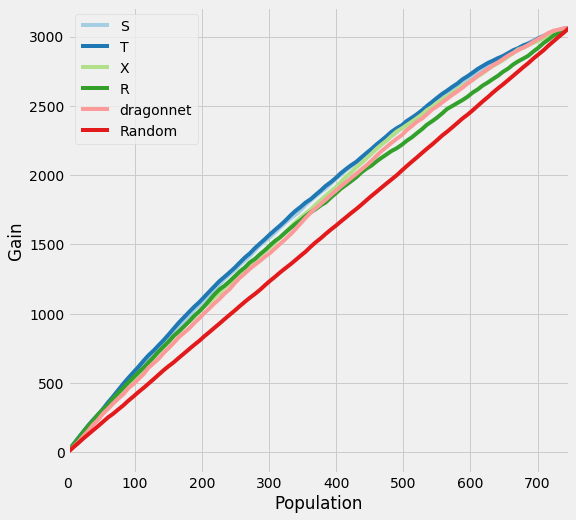

In [85]:
plot_gain(df_preds)

# `causalml` Synthetic Data Generation Method

In [23]:
y, X, w, tau, b, e = simulate_nuisance_and_easy_treatment(n=1000)

X_train, X_val, y_train, y_val, w_train, w_val, tau_train, tau_val, b_train, b_val, e_train, e_val = \
    train_test_split(X, y, w, tau, b, e, test_size=0.2, random_state=123, shuffle=True)

preds_dict_train = {}
preds_dict_valid = {}

preds_dict_train['Actuals'] = tau_train
preds_dict_valid['Actuals'] = tau_val

preds_dict_train['generated_data'] = {
    'y': y_train,
    'X': X_train,
    'w': w_train,
    'tau': tau_train,
    'b': b_train,
    'e': e_train}
preds_dict_valid['generated_data'] = {
    'y': y_val,
    'X': X_val,
    'w': w_val,
    'tau': tau_val,
    'b': b_val,
    'e': e_val}

# Predict p_hat because e would not be directly observed in real-life
p_model = ElasticNetPropensityModel()
p_hat_train = p_model.fit_predict(X_train, w_train)
p_hat_val = p_model.fit_predict(X_val, w_val)

for base_learner, label_l in zip([BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor],
                                 ['S', 'T', 'X', 'R']):
    for model, label_m in zip([LinearRegression, XGBRegressor], ['LR', 'XGB']):
        # RLearner will need to fit on the p_hat
        if label_l != 'R':
            learner = base_learner(model())
            # fit the model on training data only
            learner.fit(X=X_train, treatment=w_train, y=y_train)
            try:
                preds_dict_train['{} Learner ({})'.format(
                    label_l, label_m)] = learner.predict(X=X_train, p=p_hat_train).flatten()
                preds_dict_valid['{} Learner ({})'.format(
                    label_l, label_m)] = learner.predict(X=X_val, p=p_hat_val).flatten()
            except TypeError:
                preds_dict_train['{} Learner ({})'.format(
                    label_l, label_m)] = learner.predict(X=X_train, treatment=w_train, y=y_train).flatten()
                preds_dict_valid['{} Learner ({})'.format(
                    label_l, label_m)] = learner.predict(X=X_val, treatment=w_val, y=y_val).flatten()
        else:
            learner = base_learner(model())
            learner.fit(X=X_train, p=p_hat_train, treatment=w_train, y=y_train)
            preds_dict_train['{} Learner ({})'.format(
                label_l, label_m)] = learner.predict(X=X_train).flatten()
            preds_dict_valid['{} Learner ({})'.format(
                label_l, label_m)] = learner.predict(X=X_val).flatten()

learner = DragonNet(verbose=False)
learner.fit(X_train, treatment=w_train, y=y_train)
preds_dict_train['DragonNet'] = learner.predict_tau(X=X_train).flatten()
preds_dict_valid['DragonNet'] = learner.predict_tau(X=X_val).flatten()

In [24]:
actuals_train = preds_dict_train['Actuals']
actuals_validation = preds_dict_valid['Actuals']

synthetic_summary_train = pd.DataFrame({label: [preds.mean(), mse(preds, actuals_train)] for label, preds
                                        in preds_dict_train.items() if 'generated' not in label.lower()},
                                       index=['ATE', 'MSE']).T
synthetic_summary_train['Abs % Error of ATE'] = np.abs(
    (synthetic_summary_train['ATE']/synthetic_summary_train.loc['Actuals', 'ATE']) - 1)

synthetic_summary_validation = pd.DataFrame({label: [preds.mean(), mse(preds, actuals_validation)]
                                             for label, preds in preds_dict_valid.items()
                                             if 'generated' not in label.lower()},
                                            index=['ATE', 'MSE']).T
synthetic_summary_validation['Abs % Error of ATE'] = np.abs(
    (synthetic_summary_validation['ATE']/synthetic_summary_validation.loc['Actuals', 'ATE']) - 1)

# calculate kl divergence for training
for label in synthetic_summary_train.index:
    stacked_values = np.hstack((preds_dict_train[label], actuals_train))
    stacked_low = np.percentile(stacked_values, 0.1)
    stacked_high = np.percentile(stacked_values, 99.9)
    bins = np.linspace(stacked_low, stacked_high, 100)

    distr = np.histogram(preds_dict_train[label], bins=bins)[0]
    distr = np.clip(distr/distr.sum(), 0.001, 0.999)
    true_distr = np.histogram(actuals_train, bins=bins)[0]
    true_distr = np.clip(true_distr/true_distr.sum(), 0.001, 0.999)

    kl = entropy(distr, true_distr)
    synthetic_summary_train.loc[label, 'KL Divergence'] = kl

# calculate kl divergence for validation
for label in synthetic_summary_validation.index:
    stacked_values = np.hstack((preds_dict_valid[label], actuals_validation))
    stacked_low = np.percentile(stacked_values, 0.1)
    stacked_high = np.percentile(stacked_values, 99.9)
    bins = np.linspace(stacked_low, stacked_high, 100)

    distr = np.histogram(preds_dict_valid[label], bins=bins)[0]
    distr = np.clip(distr/distr.sum(), 0.001, 0.999)
    true_distr = np.histogram(actuals_validation, bins=bins)[0]
    true_distr = np.clip(true_distr/true_distr.sum(), 0.001, 0.999)

    kl = entropy(distr, true_distr)
    synthetic_summary_validation.loc[label, 'KL Divergence'] = kl

In [43]:
df_preds_train = pd.DataFrame([preds_dict_train['S Learner (LR)'].ravel(),
                               preds_dict_train['S Learner (XGB)'].ravel(),
                               preds_dict_train['T Learner (LR)'].ravel(),
                               preds_dict_train['T Learner (XGB)'].ravel(),
                               preds_dict_train['X Learner (LR)'].ravel(),
                               preds_dict_train['X Learner (XGB)'].ravel(),
                               preds_dict_train['R Learner (LR)'].ravel(),
                               preds_dict_train['R Learner (XGB)'].ravel(),                               
                               preds_dict_train['DragonNet'].ravel(),
                               preds_dict_train['generated_data']['tau'].ravel(),
                               preds_dict_train['generated_data']['w'].ravel(),
                               preds_dict_train['generated_data']['y'].ravel()],
                              index=['S Learner (LR)','S Learner (XGB)',
                                     'T Learner (LR)','T Learner (XGB)',
                                     'X Learner (LR)','X Learner (XGB)',
                                     'R Learner (LR)','R Learner (XGB)',
                                     'DragonNet','tau','w','y']).T

synthetic_summary_train['AUUC'] = auuc_score(df_preds_train).iloc[:-1]



In [46]:
df_preds_validation = pd.DataFrame([preds_dict_valid['S Learner (LR)'].ravel(),
                               preds_dict_valid['S Learner (XGB)'].ravel(),
                               preds_dict_valid['T Learner (LR)'].ravel(),
                               preds_dict_valid['T Learner (XGB)'].ravel(),
                               preds_dict_valid['X Learner (LR)'].ravel(),
                               preds_dict_valid['X Learner (XGB)'].ravel(),
                               preds_dict_valid['R Learner (LR)'].ravel(),
                               preds_dict_valid['R Learner (XGB)'].ravel(),                               
                               preds_dict_valid['DragonNet'].ravel(),
                               preds_dict_valid['generated_data']['tau'].ravel(),
                               preds_dict_valid['generated_data']['w'].ravel(),
                               preds_dict_valid['generated_data']['y'].ravel()],
                              index=['S Learner (LR)','S Learner (XGB)',
                                     'T Learner (LR)','T Learner (XGB)',
                                     'X Learner (LR)','X Learner (XGB)',
                                     'R Learner (LR)','R Learner (XGB)',
                                     'DragonNet','tau','w','y']).T

synthetic_summary_validation['AUUC'] = auuc_score(df_preds_validation).iloc[:-1]

In [47]:
synthetic_summary_train

,ATE,MSE,Abs % Error of ATE,KL Divergence,AUUC
Actuals,0.484486,0.000000,0.000000,0.000000,NaN
S Learner (LR),0.528743,0.044194,0.091349,3.473087,0.492660
S Learner (XGB),0.315706,0.060831,0.348369,0.423556,0.575274
T Learner (LR),0.493815,0.022688,0.019255,0.289978,0.610855
T Learner (XGB),0.443124,0.359123,0.085374,0.785408,0.544435
X Learner (LR),0.493815,0.022688,0.019255,0.289978,0.610855
X Learner (XGB),0.364116,0.205326,0.248448,0.530261,0.554322
R Learner (LR),0.473947,0.026080,0.021752,0.352075,0.613613
R Learner (XGB),0.376447,0.499069,0.222997,0.847715,0.527988
DragonNet,0.408403,0.042945,0.157038,0.434239,0.612939


In [48]:
synthetic_summary_validation

,ATE,MSE,Abs % Error of ATE,KL Divergence,AUUC
Actuals,0.511242,0.000000,0.000000,0.000000,NaN
S Learner (LR),0.528743,0.042236,0.034233,4.574498,0.494022
S Learner (XGB),0.341574,0.066174,0.331874,0.779572,0.567832
T Learner (LR),0.541503,0.025840,0.059191,0.686602,0.604712
T Learner (XGB),0.467758,0.303262,0.085055,0.942250,0.550549
X Learner (LR),0.541503,0.025840,0.059191,0.686602,0.604712
X Learner (XGB),0.364071,0.164907,0.287869,0.648777,0.555098
R Learner (LR),0.526938,0.029887,0.030702,0.739050,0.607303
R Learner (XGB),0.428291,0.324614,0.162253,0.732380,0.536405
DragonNet,0.460422,0.041291,0.099405,0.843017,0.606557


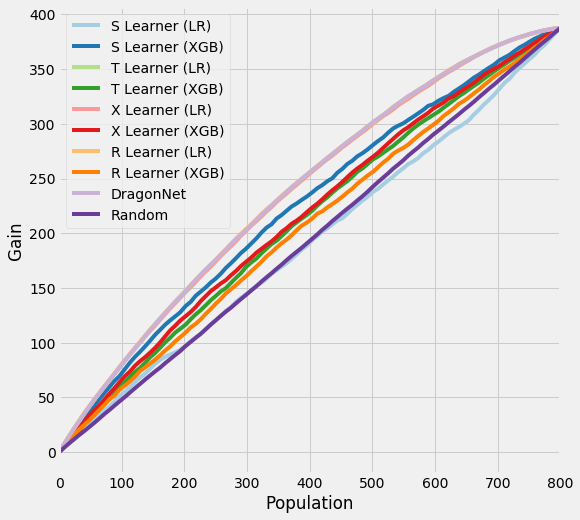

In [57]:
plot_gain(df_preds_train)

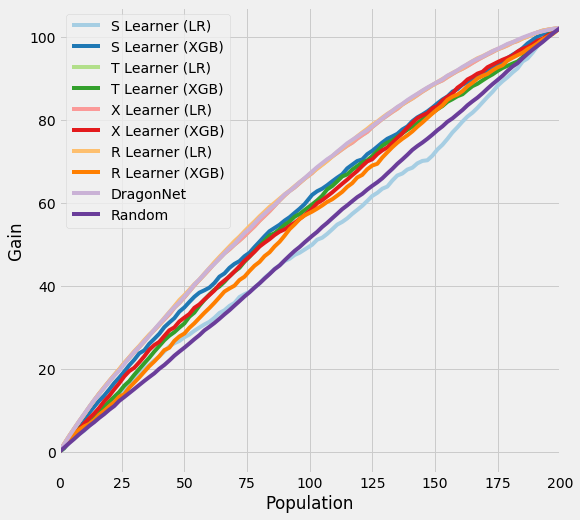

In [58]:
plot_gain(df_preds_validation)